# Plots

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from naslib import utils
from naslib.search_spaces import NasBench301SearchSpace, NasBench201SearchSpace, NasBench101SearchSpace
from naslib.search_spaces.core import Metric
from tiers import JaCovTier, TrainingSpeedEstimateTier
from scipy.stats import pearsonr
from pathlib import Path

pd.options.mode.chained_assignment = None

## Correlations

In [2]:
config = utils.load_config('config.yaml')
dataset_api = utils.get_dataset_api(search_space=config.search_space, dataset=config.dataset)
train_loader, _, _, _, _ = utils.get_train_val_loaders(config, mode="train")

def evaluate_arches(evaluator, key, path, N=500):
    arches = list()
    for _ in tqdm(range(N)):
        arch = NasBench201SearchSpace()
        arch.sample_random_architecture(dataset_api=dataset_api)
        arches.append({
            'acc': arch.query(Metric.VAL_ACCURACY, 'cifar10', dataset_api=dataset_api),
            key: evaluator.evaluate(arch)
        })
        
    with open(path, 'w') as f:
        f.write(json.dumps(arches))


def plot_corr(path, key):
    with open(path, 'r') as f:
        t = json.loads(f.read())
    real = np.asarray([x['acc'] for x in t])
    pred = np.asarray([x[key] for x in t])
    plt.scatter(real, pred)
    plt.xlabel("Real ranking")
    plt.ylabel("Predicted ranking")
    plt.title(f"Pearson r = {pearsonr(real, pred)[0]:.03}")
    plt.savefig(Path(path).with_suffix('.png'))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


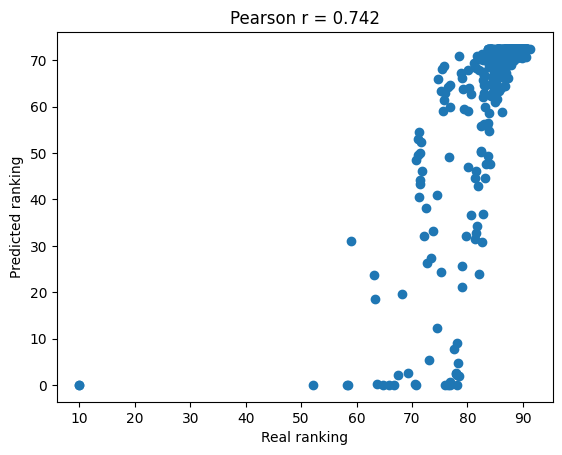

In [3]:
plot_corr('results/JaCov_vs_acc.json', 'jacov')

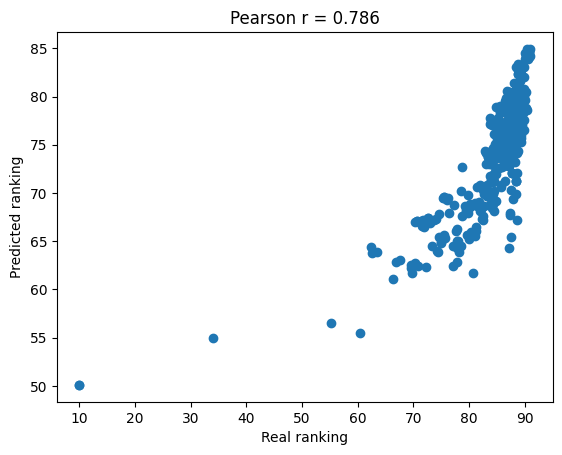

In [4]:
plot_corr('results/TSE_vs_acc.json', 'tse')

## Averages

In [5]:
def plot_averages(path, switch=np.asarray([100, 200]), pop_size=50):
    df = pd.read_json(path).dropna(axis=1, how='all')
    df.columns = pd.MultiIndex.from_tuples(df.columns.map(eval)).rename(['algorithm', 'seed'], level=[0, 1])
    df.index.rename('epoch', inplace=True)
    std = df.stack([0, 1]).groupby(['epoch', 'algorithm']).std().unstack(1).drop(('estm', 're'), axis=1)
    df = df.stack([0, 1]).groupby(['epoch', 'algorithm']).mean().unstack(1).drop(('estm', 're'), axis=1)
    df.true.re[50:50 + df.true.re.dropna().shape[0]] = df.true.re.dropna()
    df.true.re[:50] = np.nan
    std.true.re[50:50 + std.true.re.dropna().shape[0]] = std.true.re.dropna()
    std.true.re[:50] = np.nan
    df.columns, std.columns = [[f"{y.upper()}, {'estimated' if x == 'estm' else x}" for x, y in df.columns]]*2
    ax = df.plot()
    for col in std.columns:
        ax.fill_between(std.index, df[col] + std[col], df[col] - std[col], alpha=0.5)
    ax.vlines(switch, np.nanmin((df - std).to_numpy()), np.nanmax((df + std).to_numpy()),  color='gray', linestyle='--', label='Tier switch')
    if pop_size is not None: ax.vlines(switch + pop_size, np.nanmin((df - std).to_numpy()), np.nanmax((df + std).to_numpy()),  color='black', linestyle=':', label='All new evaluations')
    ax.legend()
    plt.savefig(Path(path).with_suffix('.png'))
    plt.show()

### Ablation

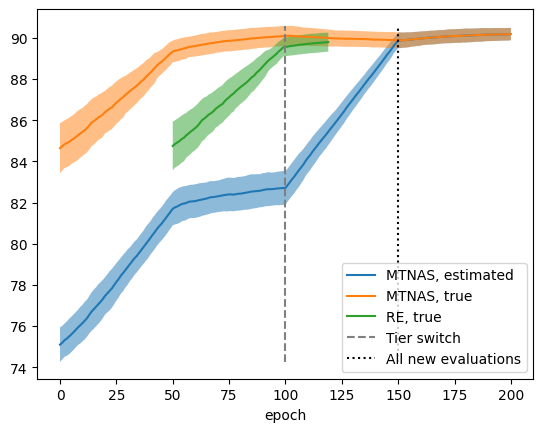

In [6]:
plot_averages('experiments/results/nasbench201/cifar10/tier1absent/averages.json', switch=np.asarray([100]))

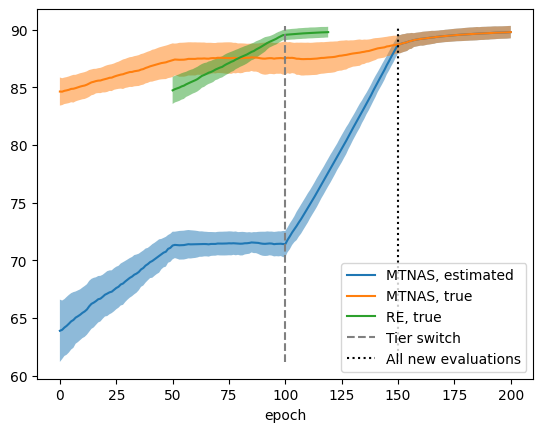

In [7]:
plot_averages('experiments/results/nasbench201/cifar10/tier2absent/averages.json', switch=np.asarray([100]))

### NAS Bench 201

#### default

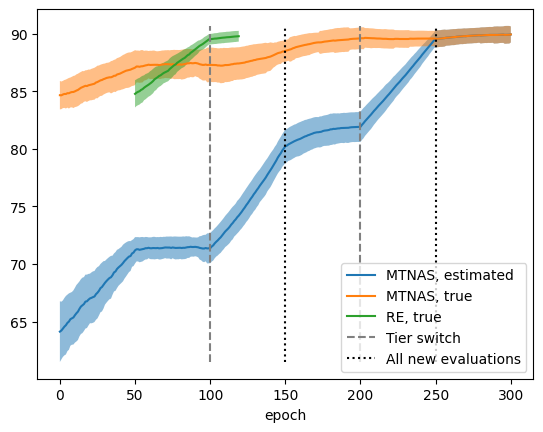

In [8]:
plot_averages('experiments/results/nasbench201/cifar10/default/averages.json')

#### cifar100default

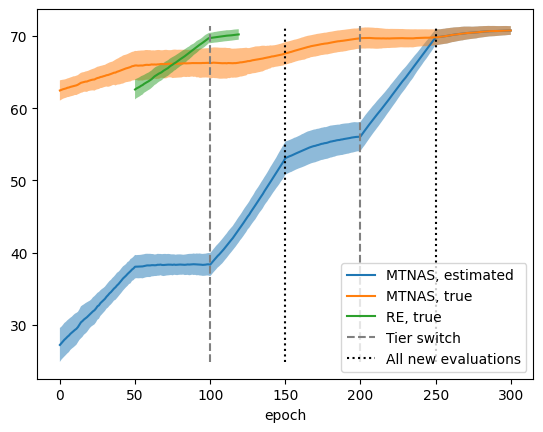

In [9]:
plot_averages('experiments/results/nasbench201/cifar100/default/averages.json')

#### in120default

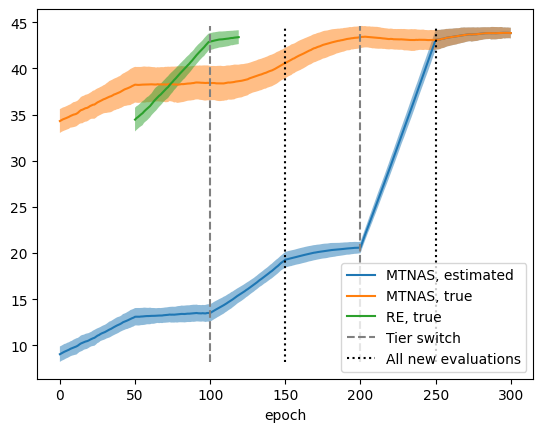

In [10]:
plot_averages('experiments/results/nasbench201/ImageNet16-120/default/averages.json')

#### tse

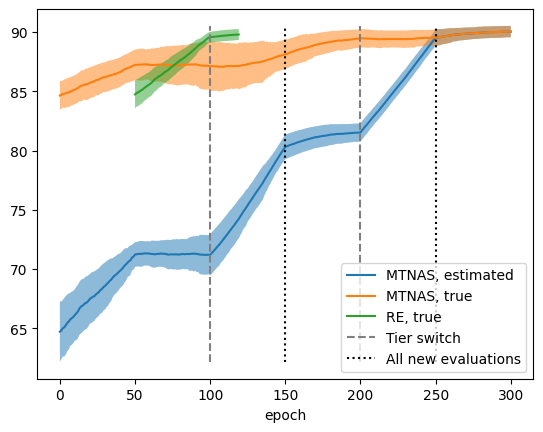

In [11]:
plot_averages('experiments/results/nasbench201/cifar10/tier2sum/averages.json')

#### tier1high

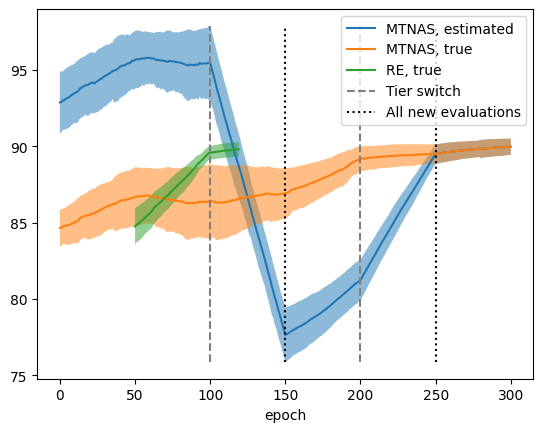

In [12]:
plot_averages('experiments/results/nasbench201/cifar10/tier1high/averages.json')

#### tier2high

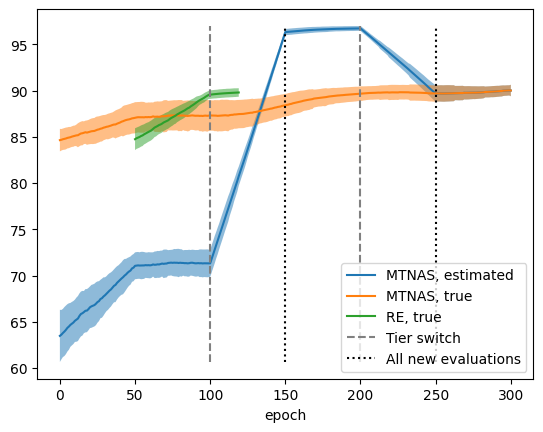

In [13]:
plot_averages('experiments/results/nasbench201/cifar10/tier2high/averages.json')

#### equal

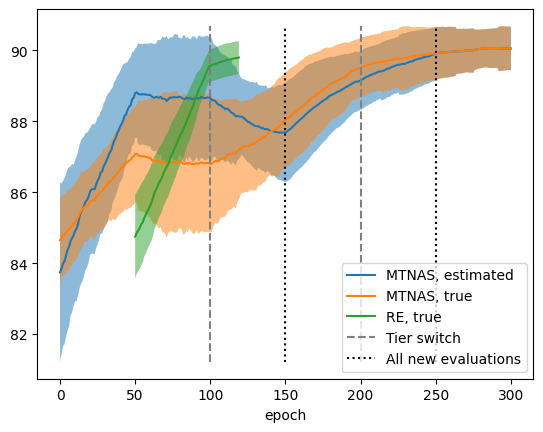

In [14]:
plot_averages('experiments/results/nasbench201/cifar10/equal/averages.json')

#### disjoint

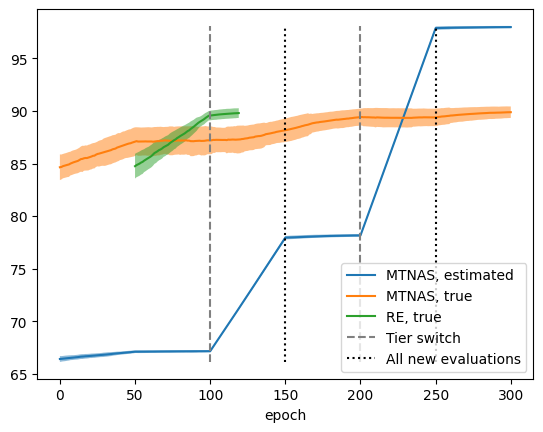

In [15]:
plot_averages('experiments/results/nasbench201/cifar10/disjoint/averages.json')

#### reevaluate

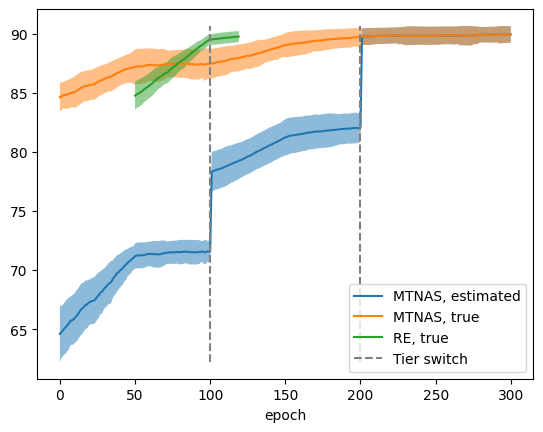

In [16]:
plot_averages('experiments/results/nasbench201/cifar10/reevaluate/averages.json', pop_size=None)

#### adjusted reevaluate

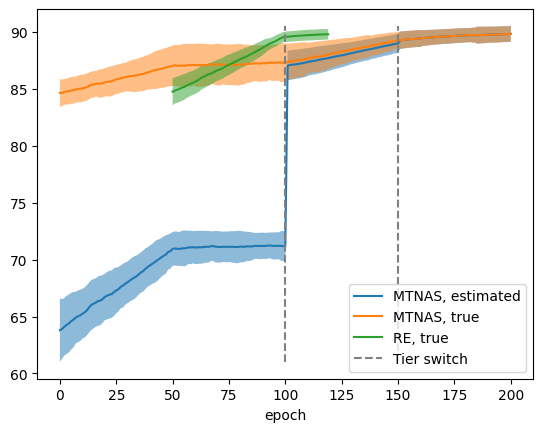

In [17]:
plot_averages('experiments/results/nasbench201/cifar10/adj_reevaluate/averages.json', switch=np.asarray([100, 150]), pop_size=None)